In [1]:
import jax.numpy as np
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

import lineax
import jax
import optax
import optimistix

from make_pulse_and_trace import MakePulse, apply_noise

from utilities import MyNamespace

In [2]:
pulse_maker=MakePulse(N=128*10, Deltaf=4) # Deltaf should be 3 for thg and 2 for shg -> depends on central_f is guess, currently 0.5
# ifrog -> Deltaf controls temporal resolution and needs to be sufficiently large 


pulse_maker.multi_pulse_time_domain_length_multiplier=8
pulse_maker.multi_pulse_parameters=[[50, 50], [5, 5, 5], [0.5, 0.25, 0.25], [1, 1, 1], ["flat", "flat", "flat"], [None, None, None]] 

time_inp, pulse_t_inp, frequency_inp, pulse_f_inp=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.3, 0.1], type="polynomial", parameters_phase=[1/4,0,0,1500,0], 
                                                                               multi_pulse_parameters=None)#pulse_maker.multi_pulse_parameters)

input_pulses=pulse_maker.input_pulses





time_gate, pulse_t_gate, frequency_gate, pulse_f_gate=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.41,0.01], type="polynomial", parameters_phase=[3/4,0,0,0], 
                                                                                   multi_pulse_parameters=None)

input_pulses_gate=pulse_maker.input_pulses

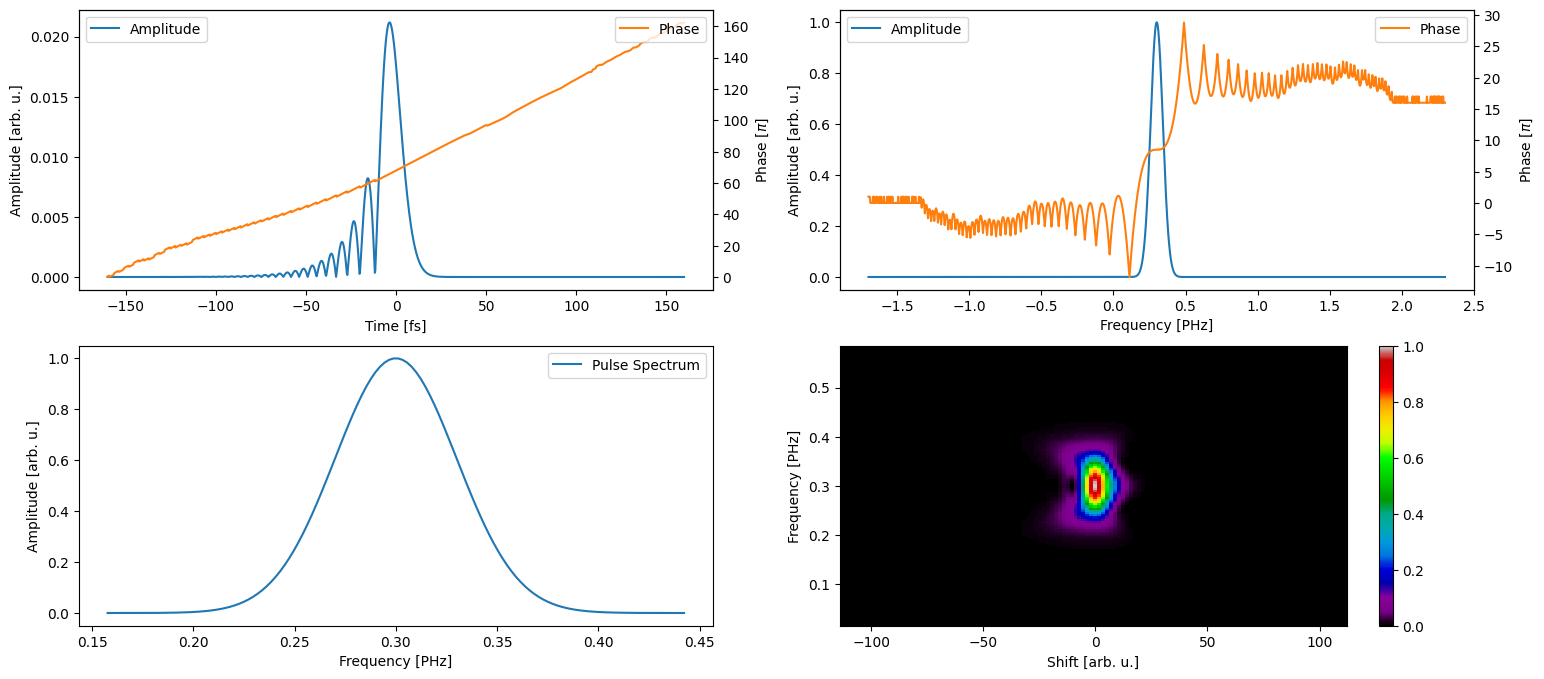

In [3]:
time, frequency, trace, spectra=pulse_maker.generate_frog_trace_and_spectrum(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, nonlinear_method="pg", 
                                                                                                  scale_time_range=5, N=128, xfrog=False, 
                                                                                                  gate=(frequency_gate, pulse_f_gate),
                                                                                                  interpolate_fft_conform=True, cut_off_val=1e-2,
                                                                                                  ifrog=False)#, frequency_range=(0,1))

#trace = apply_noise(trace, scale_val=(0.05, 0.05), additive_noise=True, multiplicative_noise=True)

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


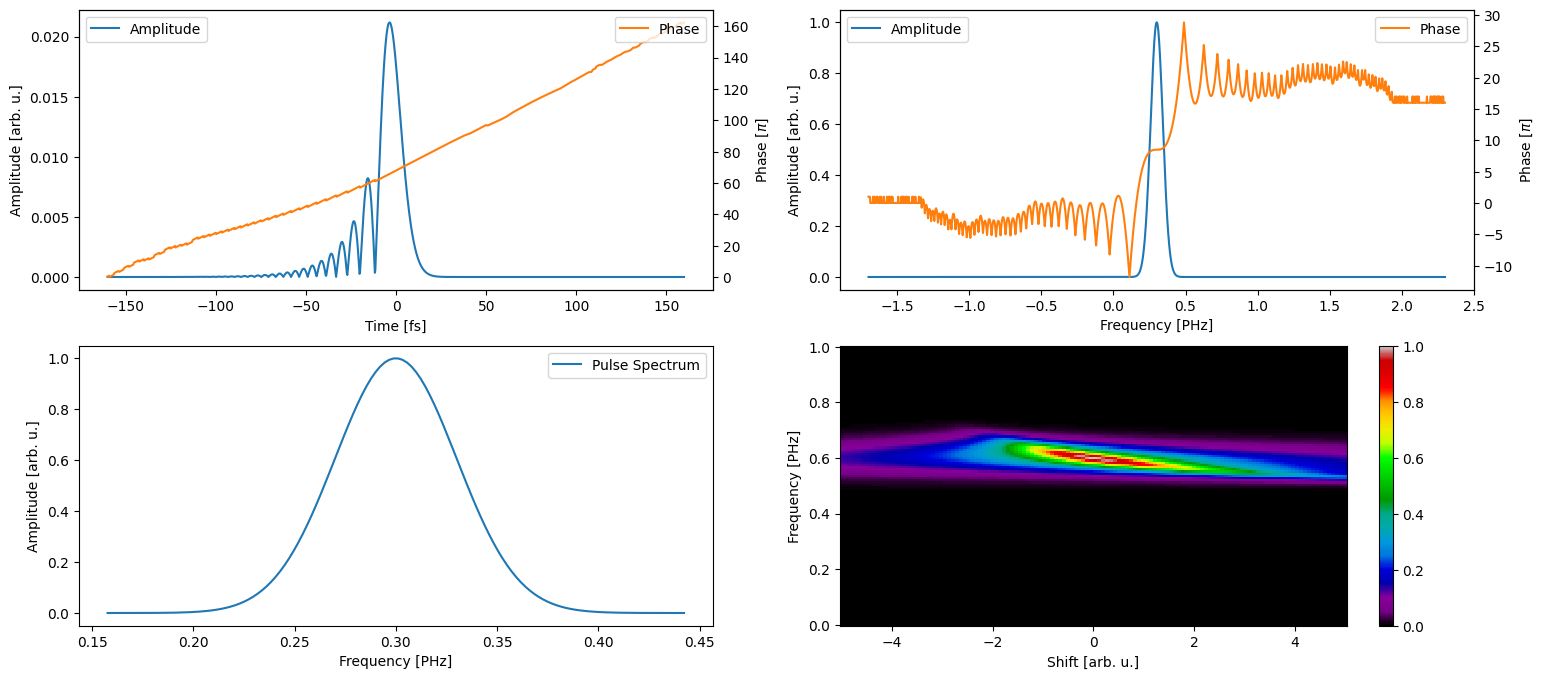

In [4]:
z_arr=np.linspace(-5, 5, 128)
#pulse_t, pulse_f=pulse_maker.precompensate_pulse_for_dscan(time, frequency, pulse_t, GDD=-5000, TOD=0, central_f=0.5)
z_arr, frequency, trace, spectra = pulse_maker.generate_dscan_trace_and_spectrum(z_arr, time_inp, frequency_inp, pulse_t_inp, pulse_f_inp,
                                                                                                   nonlinear_method="shg", 
                                                                                                   N=128, cut_off_val=1e-3, frequency_range=(0,1))


#trace = apply_noise(trace, scale_val=0.01, additive_noise=True, multiplicative_noise=False)

# if there are weird stripes in the trace -> set Deltaf=2 somehow thats needed

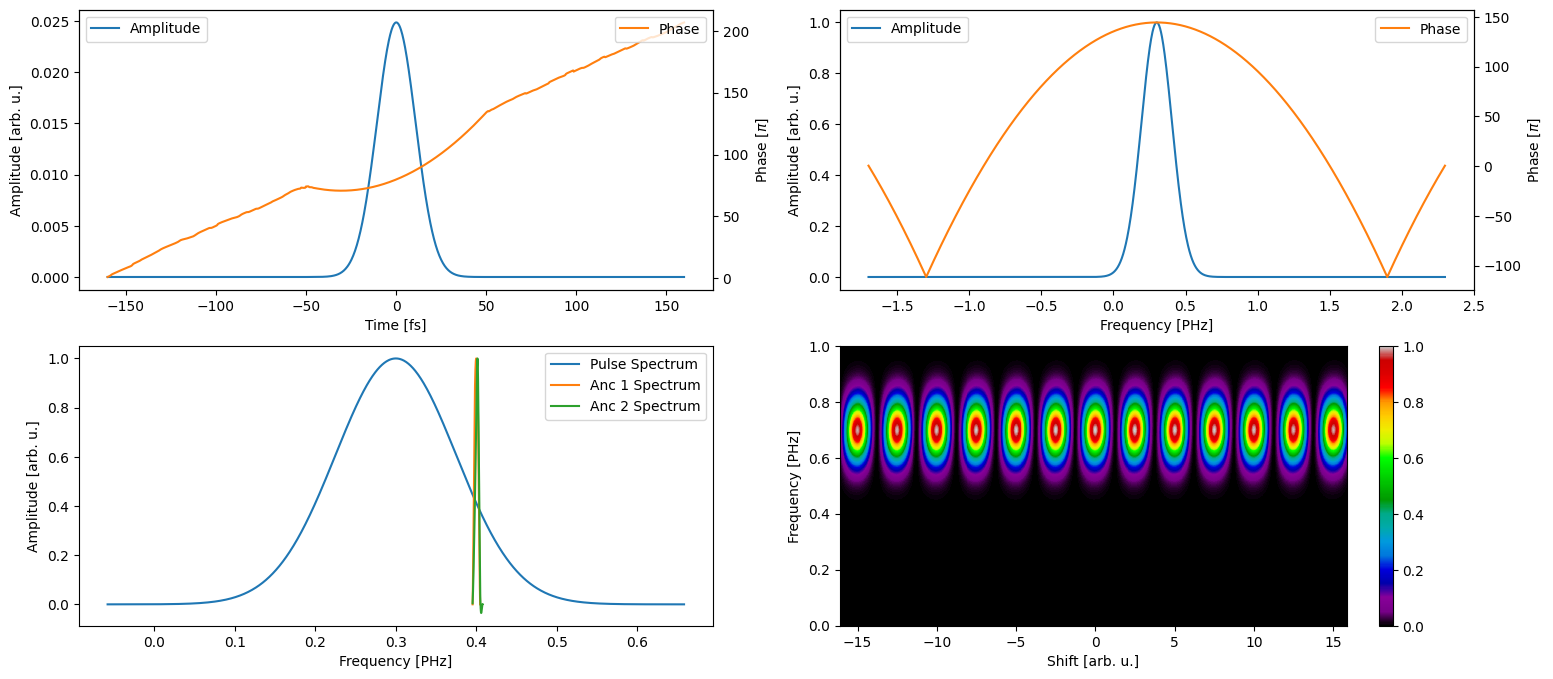

In [34]:
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.3, 0.25], type="polynomial", parameters_phase=[1/4,0,-50,0,0], 
                                                                               multi_pulse_parameters=None)#pulse_maker.multi_pulse_parameters)

_, _, frequency_gate_1, pulse_f_gate_1=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.4,0.001], type="polynomial", parameters_phase=[0,0,0,0], 
                                                                                   multi_pulse_parameters=None)

_, _, frequency_gate_2, pulse_f_gate_2=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.401,0.001], type="polynomial", parameters_phase=[0,0,0,0], 
                                                                                   multi_pulse_parameters=None)

time, frequency, trace, spectra=pulse_maker.generate_2dsi_trace_and_spectrum(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, "shg", 
                                                                             anc=((frequency_gate_1, pulse_f_gate_1),
                                                                                  (frequency_gate_2, pulse_f_gate_2)), 
                                                                             N=256*4, scale_time_range=0.1, plot_stuff=True, cut_off_val=0.001, frequency_range=(0,1))

In [35]:
from classic_algorithms_2dsi import DirectReconstruction

In [36]:
dr = DirectReconstruction(time, frequency, trace, "shg", True, 0.4, 0.401).use_measured_spectrum(spectra.pulse[0], spectra.pulse[1])
anc1 = dr.get_anc_pulse(frequency_gate_1, pulse_f_gate_1, anc_no=1)
anc2 = dr.get_anc_pulse(frequency_gate_2, pulse_f_gate_2, anc_no=2)

population = dr.create_initial_population(1)

In [37]:
final_result = dr.run(population, no_iterations=1)

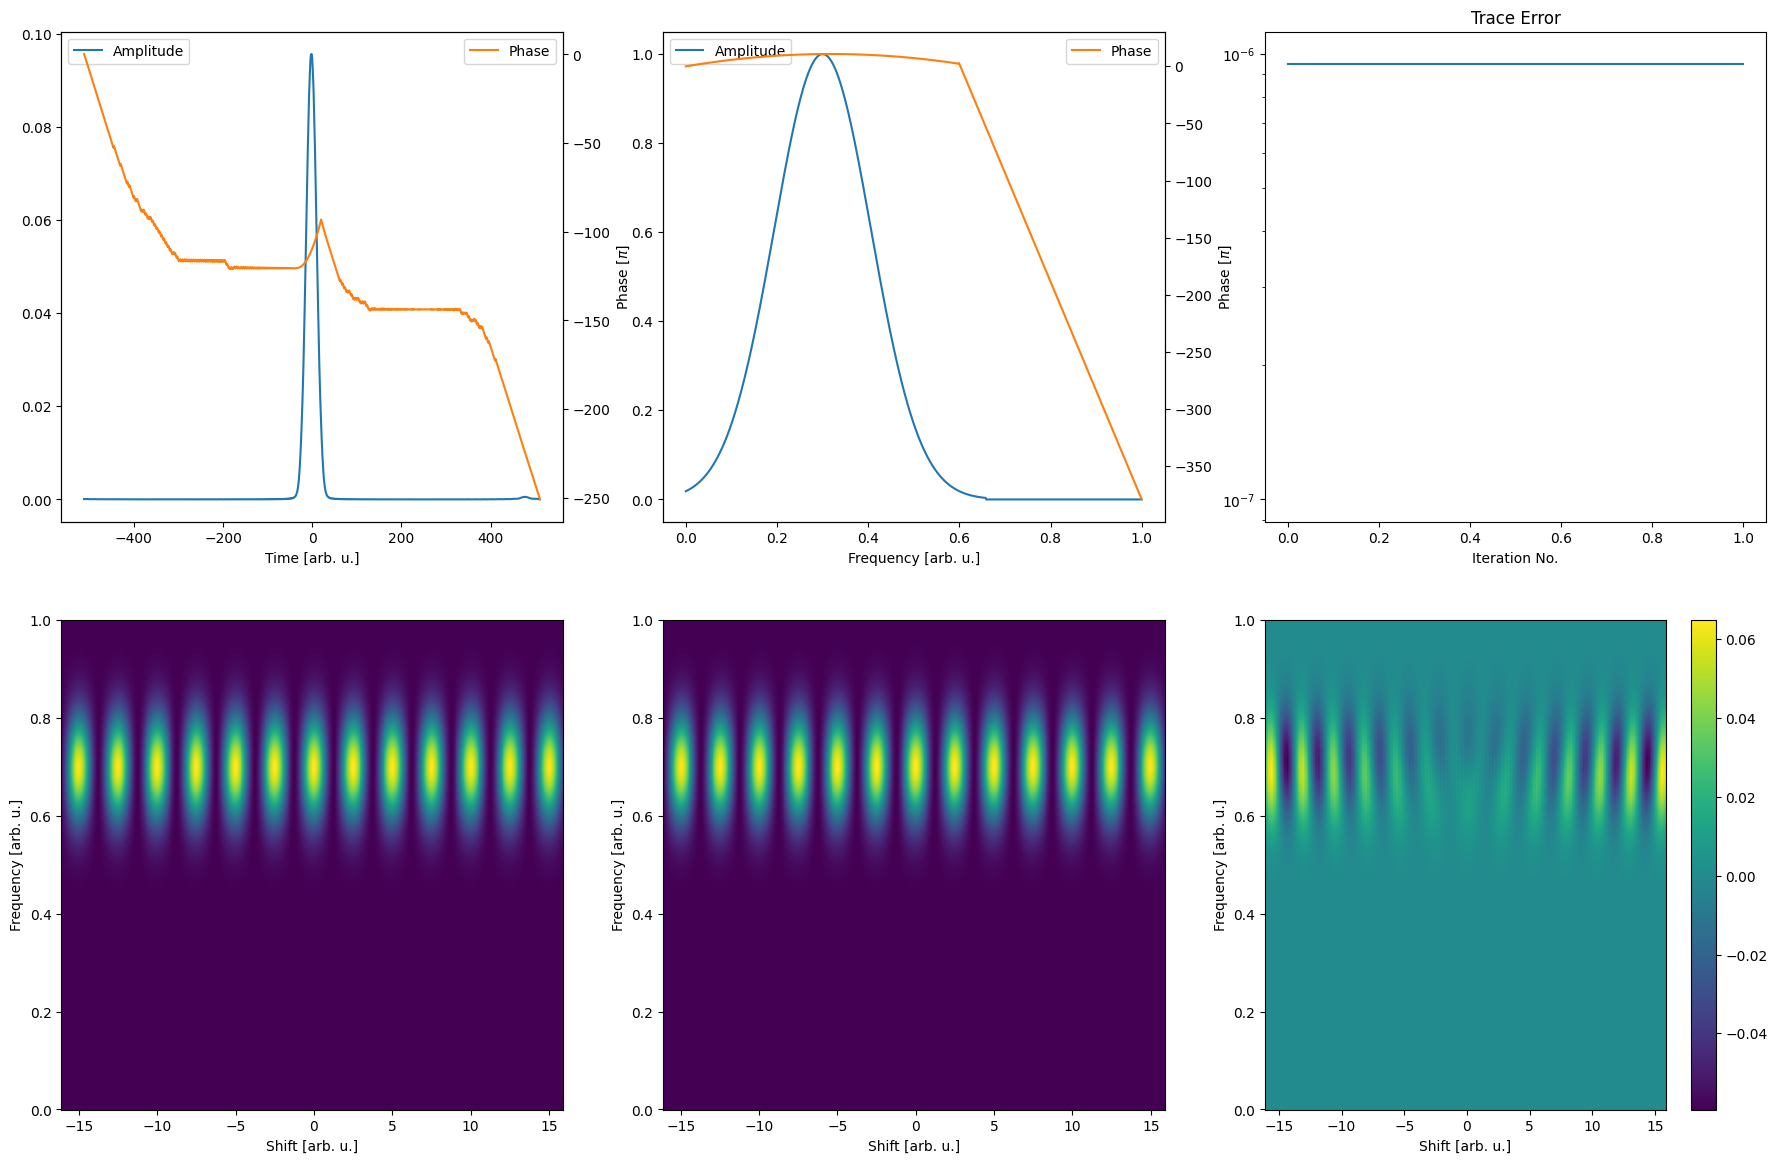

In [38]:
dr.plot_results(final_result)

In [4]:
from classic_algorithms_frog import Vanilla, LSGPA, GeneralizedProjection, TimeDomainPtychography, COPRA

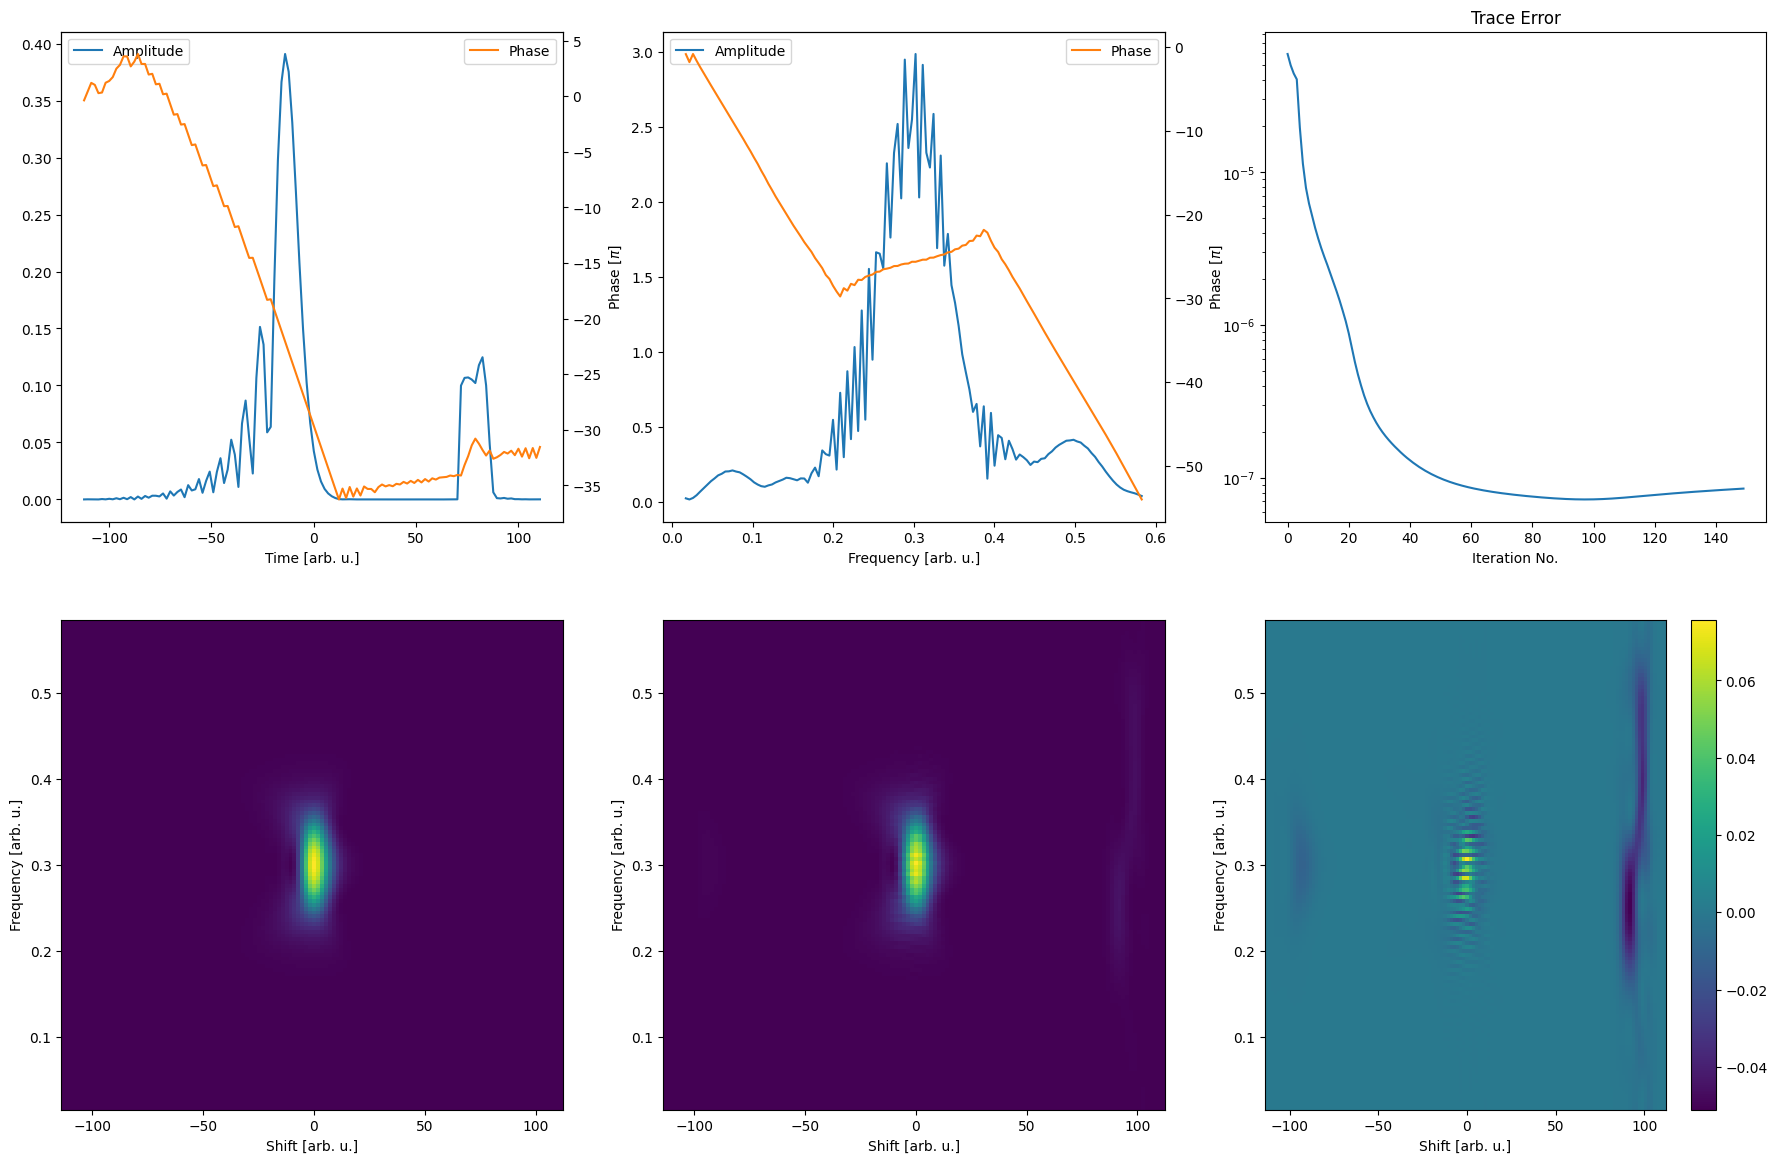

In [ ]:
# vanilla = Vanilla(time, frequency, trace, "pg")
# population = vanilla.create_initial_population(population_size=3, guess_type="random")

# final_result = vanilla.run(population, 100)
# vanilla.plot_results(final_result)






# lsgpa = LSGPA(time, frequency, trace, "pg", xfrog=False)#.use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")
# population = lsgpa.create_initial_population(population_size=3, guess_type="random")

# final_result = lsgpa.run(population, 500)
# lsgpa.plot_results(final_result)






# gp = GeneralizedProjection(time, frequency, trace, "pg", xfrog=False)
# population = gp.create_initial_population(population_size=1, guess_type="random")

# gp.global_hessian = "lbfgs"
# gp.conjugate_gradients = False


# gp.no_steps_descent = 25
# gp.max_steps_linesearch = 15
# gp.use_linesearch = "zoom"
# gp.global_gamma = 1.0
# gp.delta_gamma = 2.0
# gp.c1 = 1e-4
# gp.c2 = 0.5

# # gp.lbfgs_memory = 3

# # gp.use_copra_style_step_scaling = False


# final_result = gp.run(population, 150)
# gp.plot_results(final_result)






# tdp = TimeDomainPtychography(time, frequency, trace, "sd", "ePIE", xfrog="doubleblind")
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# tdp.alpha = 0.1
# tdp.local_gamma = 0.1
# tdp.global_gamma = 0.1

# tdp.lbfgs_memory = 15
# tdp.conjugate_gradients = False#"fletcher_reeves"

# tdp.global_hessian = "full" #"lbfgs"
# tdp.use_linesearch = "backtracking" #"wolfe"
# #tdp.lambda_lm = 1e-2

# final_result = tdp.run(population, 0, 150)
# tdp.plot_results(final_result)





# copra = COPRA(time, frequency, trace, "pg", ifrog=False)#, xfrog="doubleblind")
# population = copra.create_initial_population(population_size=5, guess_type="random")

# # copra.use_linesearch = False #"wolfe"

# # copra.local_gamma=1
# # copra.global_gamma=0.5
# # copra.local_adaptive_scaling = "original"
# # copra.global_adaptive_scaling = "original"
# # copra.xi=1e-12

# # copra.local_hessian=False
# # copra.global_hessian=False#"full"

# final_result = copra.run(population, 150, 100)
# copra.plot_results(final_result)



In [4]:
from classic_algorithms_dscan import Basic, GeneralizedProjection, TimeDomainPtychography, COPRA

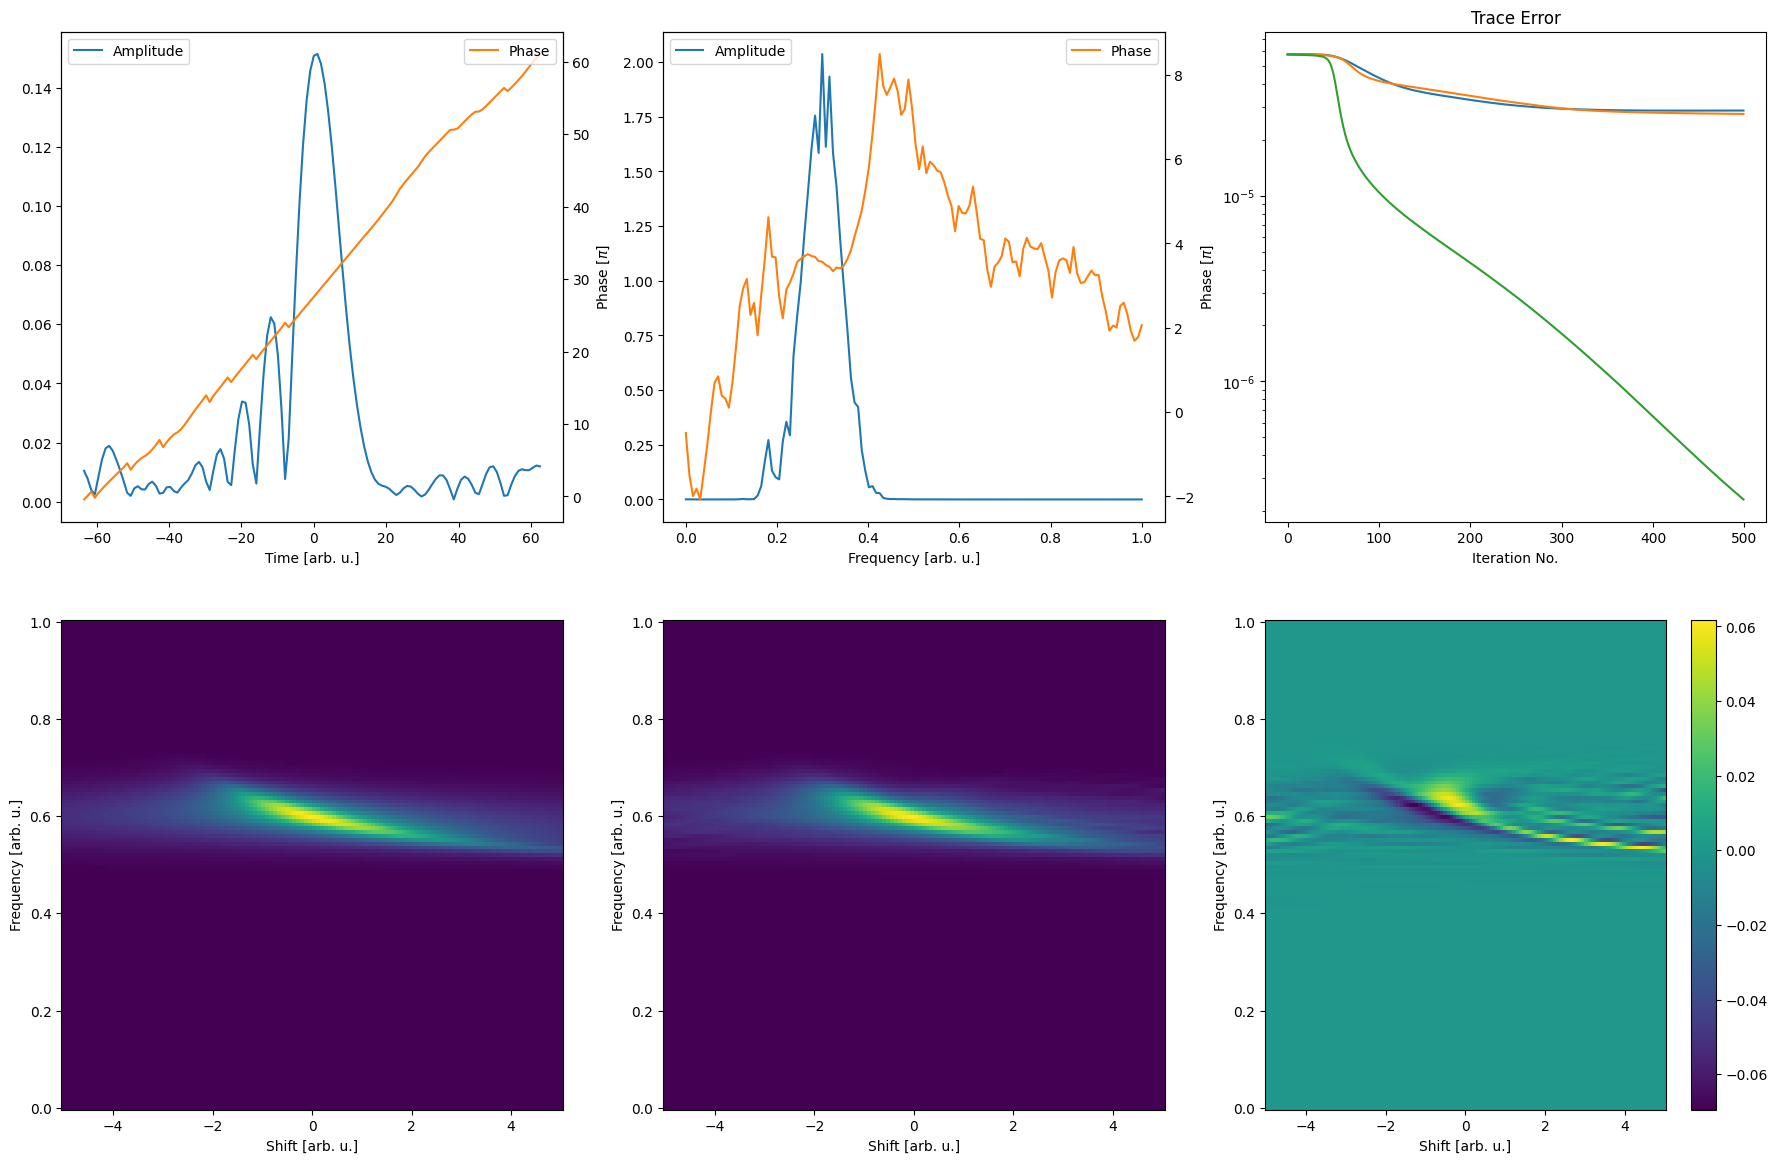

In [8]:
# basic = Basic(z_arr, frequency, trace, "shg")
# population = basic.create_initial_population(population_size=3, guess_type="random")

# final_result = basic.run(population, 100)
# basic.plot_results(final_result)





# gp = GeneralizedProjection(z_arr, frequency, trace, "shg")
# population = gp.create_initial_population(population_size=3, guess_type="random")

# # gp.global_hessian="lbfgs"#"diagonal"
# # gp.no_steps_descent=50
# # gp.gamma=1

# final_result = gp.run(population, 100)
# gp.plot_results(final_result)




tdp = TimeDomainPtychography(z_arr, frequency, trace, "shg", pie_method="rPIE")
population = tdp.create_initial_population(population_size=3, guess_type="random")

tdp.alpha=0.1
tdp.local_gamma=0.005
tdp.global_gamma=0.5

tdp.use_linesearch=False
tdp.global_hessian="diagonal"

final_result = tdp.run(population, 0, 500)
tdp.plot_results(final_result)






# copra = COPRA(z_arr, frequency, trace, "shg")
# population = copra.create_initial_population(population_size=3, guess_type="random")

# copra.local_gamma = 1
# copra.global_gamma = 0.25

# copra.local_hessian = False
# copra.global_hessian = False

# copra.adaptive_scaling = "linear"

# final_result = copra.run(population, 12, 15)
# copra.plot_results(final_result)

In [22]:
from general_algorithms_frog import DifferentialEvolution, Evosax, LSF, AutoDiff

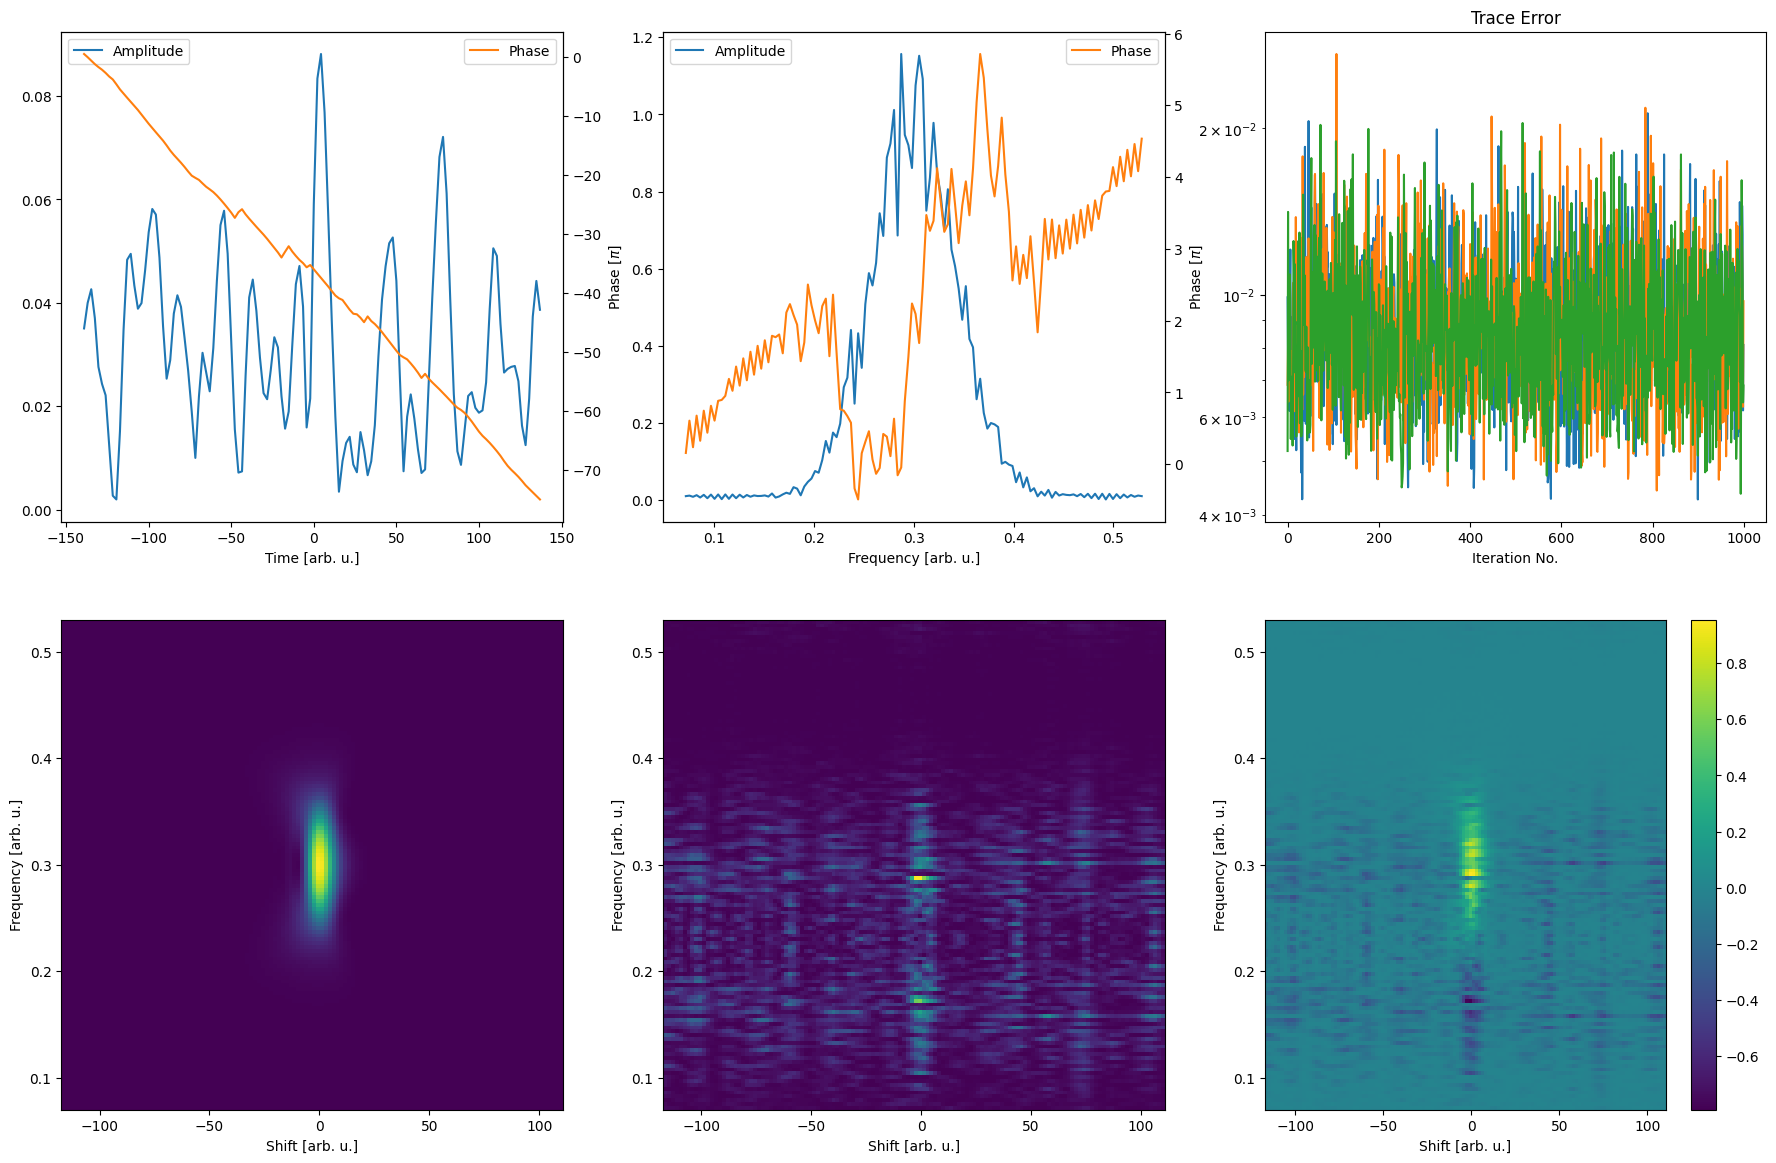

In [5]:
# de = DifferentialEvolution(time, frequency, trace, "pg", xfrog="doubleblind").use_measured_spectrum()
# spectral_amplitude = de.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = de.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = de.create_initial_population(population_size=250, amp_type="splines", phase_type="splines")

# de.strategy="best1_smooth"

# final_result = de.run(population, 150)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(time, frequency, trace, "pg", xfrog="doubleblind").use_measured_spectrum()
# spectral_amplitude = evo.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = evo.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = evo.create_initial_population(population_size=250)

# evo.solver = CMA_ES

# final_result = evo.run(population, 250)
# evo.plot_results(final_result)




lsf = LSF(time, frequency, trace, "pg", xfrog=False).use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")

population = lsf.create_initial_population(population_size=3, amp_type="discrete", phase_type="discrete")

lsf.number_of_bisection_iterations=12
lsf.random_direction_mode="random"
lsf.no_points_for_continuous=5

final_result = lsf.run(population, 1000)
lsf.plot_results(final_result)





# ad = AutoDiff(time, frequency, trace, "thg", xfrog="doubleblind").use_measured_spectrum()

# spectral_amplitude = ad.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = ad.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.alternating_optimization = True
# ad.solver = optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)

In [8]:
error_arr = jnp.copy(final_result.error_arr)

In [12]:
error_arr_rand_phase = jnp.copy(final_result.error_arr)

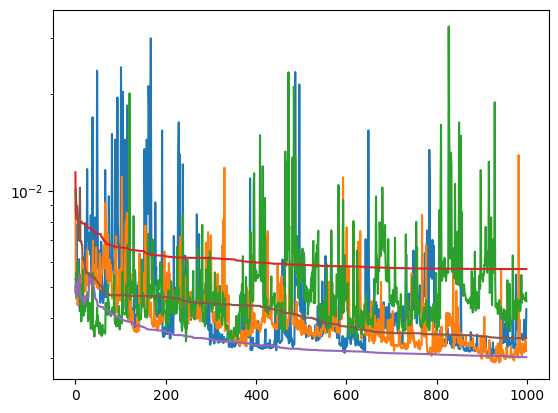

In [14]:
plt.plot(error_arr)
plt.plot(final_result.error_arr)
plt.yscale("log")

In [ ]:
from general_algorithms_dscan import DifferentialEvolution, Evosax, LSF, AutoGrad

In [ ]:
# de = DifferentialEvolution(z_arr, frequency, trace, "shg")
# population = de.create_initial_population(population_size=150)

# final_result = de.run(population, 100)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(z_arr, frequency, trace, "shg")
# evo.solver = CMA_ES
# population = evo.create_initial_population(population_size=250)

# final_result = evo.run(population, 100)
# evo.plot_results(final_result)




lsf = LSF(z_arr, frequency, trace, "shg")
population = lsf.create_initial_population(population_size=3, amp_type="random", phase_type="random")

lsf.number_of_bisection_iterations=8
lsf.random_direction_mode="random"
lsf.no_points_for_continuous=15

final_result = lsf.run(population, 2000)
lsf.plot_results(final_result)





# ad = AutoGrad(z_arr, frequency, trace, "shg")
# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.solver=optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)

In [35]:
time, frequency, trace, spectra

(array([-16.1125    , -15.98710784, -15.86171569, -15.73632353,
        -15.61093137, -15.48553922, -15.36014706, -15.2347549 ,
        -15.10936275, -14.98397059, -14.85857843, -14.73318627,
        -14.60779412, -14.48240196, -14.3570098 , -14.23161765,
        -14.10622549, -13.98083333, -13.85544118, -13.73004902,
        -13.60465686, -13.47926471, -13.35387255, -13.22848039,
        -13.10308824, -12.97769608, -12.85230392, -12.72691176,
        -12.60151961, -12.47612745, -12.35073529, -12.22534314,
        -12.09995098, -11.97455882, -11.84916667, -11.72377451,
        -11.59838235, -11.4729902 , -11.34759804, -11.22220588,
        -11.09681373, -10.97142157, -10.84602941, -10.72063725,
        -10.5952451 , -10.46985294, -10.34446078, -10.21906863,
        -10.09367647,  -9.96828431,  -9.84289216,  -9.7175    ,
         -9.59210784,  -9.46671569,  -9.34132353,  -9.21593137,
         -9.09053922,  -8.96514706,  -8.8397549 ,  -8.71436275,
         -8.58897059,  -8.46357843,  -8.

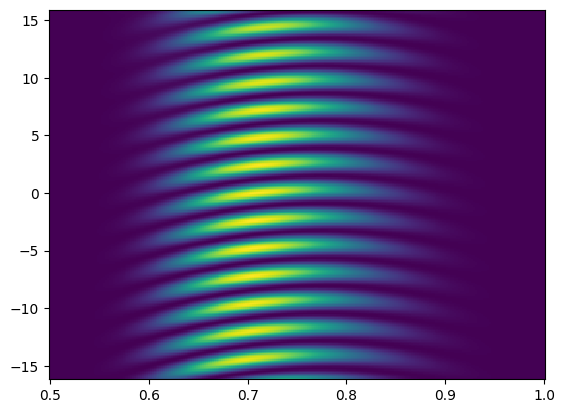

In [20]:
plt.pcolormesh(frequency, time, jnp.abs(trace))

In [ ]:
def apply_hann_window(signal, axis=-1):
    N=jnp.shape(signal)[axis]
    n=jnp.arange(N)
    hann = jnp.sin(jnp.pi*n/N)**2
    return jnp.swapaxes(jnp.swapaxes(signal, -1, axis)*hann, axis, -1)


from jax.scipy.special import bernoulli, factorial

def integrate_signal_1D(signal, x, method="cumsum"):
    dx = jnp.mean(jnp.diff(x))

    if method=="cumsum":
        signal = jnp.cumsum(signal, axis=-1)*dx
        
    elif method[:-2]=="euler_maclaurin":
        n = jnp.asarray(int(method[-1]))
        bn = bernoulli(2*n)

        y_prime = jnp.gradient(signal, x, axis=-1)
        t = dx**2/12*(y_prime[:-1] - y_prime[1:])
        for i in jnp.arange(3, 2*n+1, 2):
            f = bn[i+1]/factorial(i+1)
            y_prime = jnp.gradient(jnp.gradient(y_prime, x, axis=-1), x, axis=-1)
            t = t + dx**(i+1)*f*(y_prime[:-1] - y_prime[1:])

        # the addition of t is correct because the gradients are subtracted in reverse
        yint = dx/2*(signal[:-1] + signal[1:]) + t
        yint = jnp.concatenate((jnp.zeros(1), yint), axis=-1)
        signal = jnp.cumsum(yint, axis=-1)

    else:
        print(f"method must be one cumsum or euler_maclaurin_n. not {method}")
        
    return signal

In [259]:
from utilities import center_signal

In [282]:
def reconstruct_2dsi_1dfft(frequency, trace, pulse_spectrum, shear_frequency, integration_method):
    trace_hann = apply_hann_window(trace, axis=0)
    trace_hann = trace_hann - jnp.mean(trace_hann)
    trace_f = jnp.fft.fftshift(jnp.fft.fft(trace_hann, axis=0), axes=0)
    idx = jnp.shape(trace)[0] - jnp.argmax(jnp.sum(jnp.abs(trace_f), axis=0))

    group_delay = jnp.unwrap(jnp.angle(trace_f[idx]))/shear_frequency
    spectral_phase = integrate_signal_1D(group_delay, frequency, method=integration_method)
    spectral_phase = spectral_phase - jnp.mean(spectral_phase)
    
    pulse_f = jnp.sqrt(pulse_spectrum)*jnp.exp(1j*spectral_phase)
    pulse_t = jnp.fft.ifft(jnp.fft.fftshift(pulse_f))
    pulse_t = center_signal(pulse_t)
    return pulse_t

In [283]:
pulse_t = reconstruct_2dsi_1dfft(frequency, trace, spectra.pulse[1], 0.02, "euler_maclaurin_3")

In [324]:
shear_frequency = 0.02
integration_method = "euler_maclaurin_3"
pulse_spectrum = spectra.pulse[1]

In [330]:
trace_hann = apply_hann_window(trace, axis=0)
trace_f = jnp.fft.fftshift(jnp.fft.fft(trace_hann, axis=0), axes=0)
idx = jnp.shape(trace)[0] - jnp.argmax(jnp.sum(jnp.abs(trace_f), axis=0))

group_delay = jnp.unwrap(jnp.angle(trace_f[idx]))/shear_frequency
spectral_phase = integrate_signal_1D(group_delay, frequency, method=integration_method)
spectral_phase = spectral_phase - jnp.mean(spectral_phase)

pulse_f = jnp.sqrt(pulse_spectrum)*jnp.exp(1j*spectral_phase)
pulse_t = jnp.fft.ifft(jnp.fft.fftshift(pulse_f))
pulse_t = center_signal(pulse_t)

In [331]:
trace_f = jnp.fft.fftshift(jnp.fft.fft2(trace_hann))

In [ ]:
idx = jnp.shape(trace)[0] - jnp.argmax(jnp.sum(jnp.abs(trace_f), axis=1))

In [347]:
group_delay = jnp.unwrap(jnp.angle(trace_f[idx]))/shear_frequency

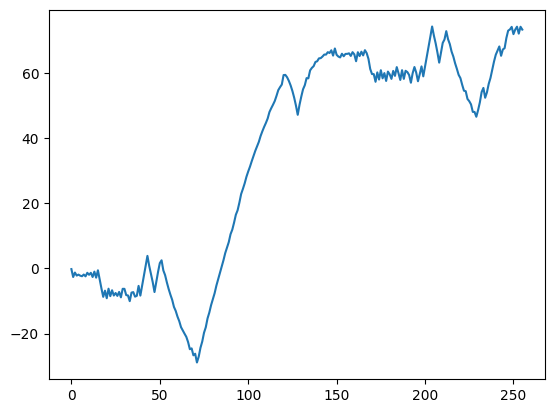

In [346]:
plt.plot(group_delay)

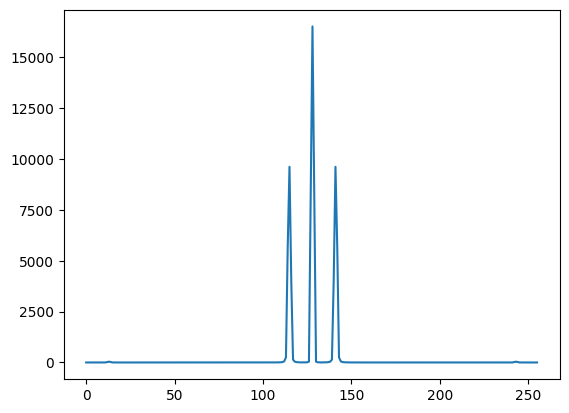

In [336]:
plt.plot(jnp.sum(jnp.abs(trace_f), axis=1))

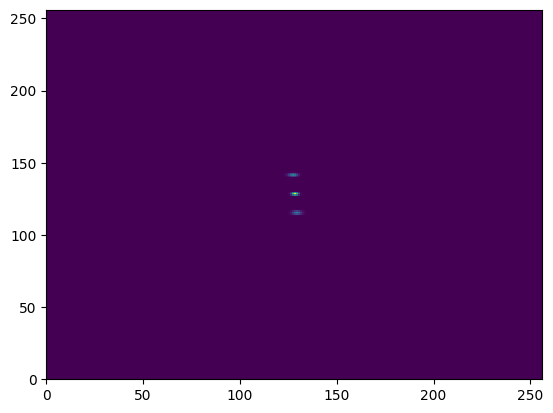

In [332]:
plt.pcolormesh(jnp.abs(trace_f))